In [1]:
from glob import glob
import pandas as pd
from pingouin import plot_paired, compute_effsize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Read the results generated by OCE.  These were generated by the script oce_model_stats.py

In [2]:
df_list = []
for filename in glob("*stats.csv"):
    df = pd.read_csv(filename)
    df_list.append(df)

Concatenate the OCE results into one dataframe.

In [3]:
oce_df = pd.concat(df_list)

Read the results from previous models on this dataset. Note that this file also contains the cross-validation splits.

In [4]:
cmp_df = pd.read_csv("../comparison.csv")

Define the training and test sets.

In [5]:
oce_df['split'] =[f"RND_{x:02d}" for x in oce_df.cycle]

Merge oce_df and cmp_df

In [6]:
merge_df = oce_df.merge(cmp_df,on=["dataset","split"])

Compare mean RMSE for 10 folds between OCE and GP

In [7]:
mean_list = []
for k,v in merge_df.groupby("dataset"):
    mean_list.append([k,v.rmse.mean(),v.gp_rmse.mean()])
mean_df = pd.DataFrame(mean_list,columns=["Dataset","OCE RMSE Mean","GP RMSE Mean"])
mean_df.round(2)

,Dataset,OCE RMSE Mean,GP RMSE Mean
0,A2a,0.74,0.69
1,ABL1,0.77,0.76
2,Acetylcholinesterase,0.70,0.71
3,Aurora-A,0.80,0.80
4,B-raf,0.63,0.64
5,COX-1,0.73,0.69
6,COX-2,0.75,0.75
7,Cannabinoid,0.71,0.70
8,Carbonic,0.61,0.57
9,Caspase,0.54,0.55


Plot a kde comparing mean RMSE between GP and OCE

<AxesSubplot:xlabel='RMSE', ylabel='Density'>

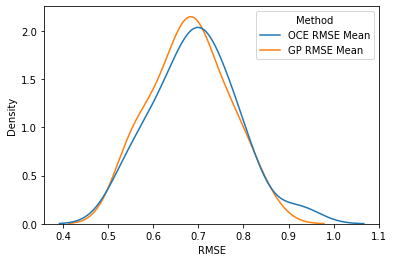

In [8]:
melt_mean_df = mean_df.melt(id_vars="Dataset")
melt_mean_df.columns = ["Dataset","Method","RMSE"]
sns.kdeplot(x="RMSE",hue="Method",data=melt_mean_df)

Calculate the effect size and associated probability

In [9]:
d = compute_effsize(mean_df["OCE RMSE Mean"],mean_df["GP RMSE Mean"],eftype="cohen")
print(f"effect size = {d:.3f}")
print(f"probability = {d*0.25+0.5:.3f}")

effect size = 0.140
probability = 0.535


Look at the merged data

In [10]:
merge_df

,dataset,cycle,r2,rmse,split,gp_r2,xgb_r2,ffnn_r2,gp_rmse,xgb_rmse,ffnn_rmse
0,Dihydrofolate,0,0.454233,0.816273,RND_00,0.441897,0.383692,0.490361,0.825447,0.867423,0.788793
1,Dihydrofolate,1,0.435802,0.843304,RND_01,0.514967,0.457922,0.523736,0.781905,0.826608,0.774805
2,Dihydrofolate,2,0.485337,0.844943,RND_02,0.580520,0.562287,0.489830,0.762819,0.779221,0.841247
3,Dihydrofolate,3,0.598059,0.790893,RND_03,0.612084,0.555411,0.630479,0.776972,0.831795,0.758327
4,Dihydrofolate,4,0.447371,0.868395,RND_04,0.483922,0.327929,0.384541,0.839186,0.957653,0.916432
...,...,...,...,...,...,...,...,...,...,...,...
235,erbB1,5,0.720655,0.725039,RND_05,0.731750,0.673241,0.682651,0.710495,0.784160,0.772787
236,erbB1,6,0.743038,0.711701,RND_06,0.742034,0.709294,0.695739,0.713091,0.756990,0.774438
237,erbB1,7,0.746977,0.681842,RND_07,0.753400,0.700943,0.716894,0.673133,0.741278,0.721238
238,erbB1,8,0.732639,0.701839,RND_08,0.732967,0.702101,0.675356,0.701408,0.740838,0.773379


Reformat the data to generate the paired plots

In [11]:
melt_df = merge_df[["dataset","cycle","rmse","gp_rmse"]].melt(id_vars=["dataset","cycle"])
melt_df.head()

,dataset,cycle,variable,value
0,Dihydrofolate,0,rmse,0.816273
1,Dihydrofolate,1,rmse,0.843304
2,Dihydrofolate,2,rmse,0.844943
3,Dihydrofolate,3,rmse,0.790893
4,Dihydrofolate,4,rmse,0.868395


Rename the fields so that plot makes sense

In [12]:
method_dict = {"rmse" : "OCE", "gp_rmse" : "GP"}
melt_df['variable'] = [method_dict[x] for x in melt_df.variable]

Make the paired plots

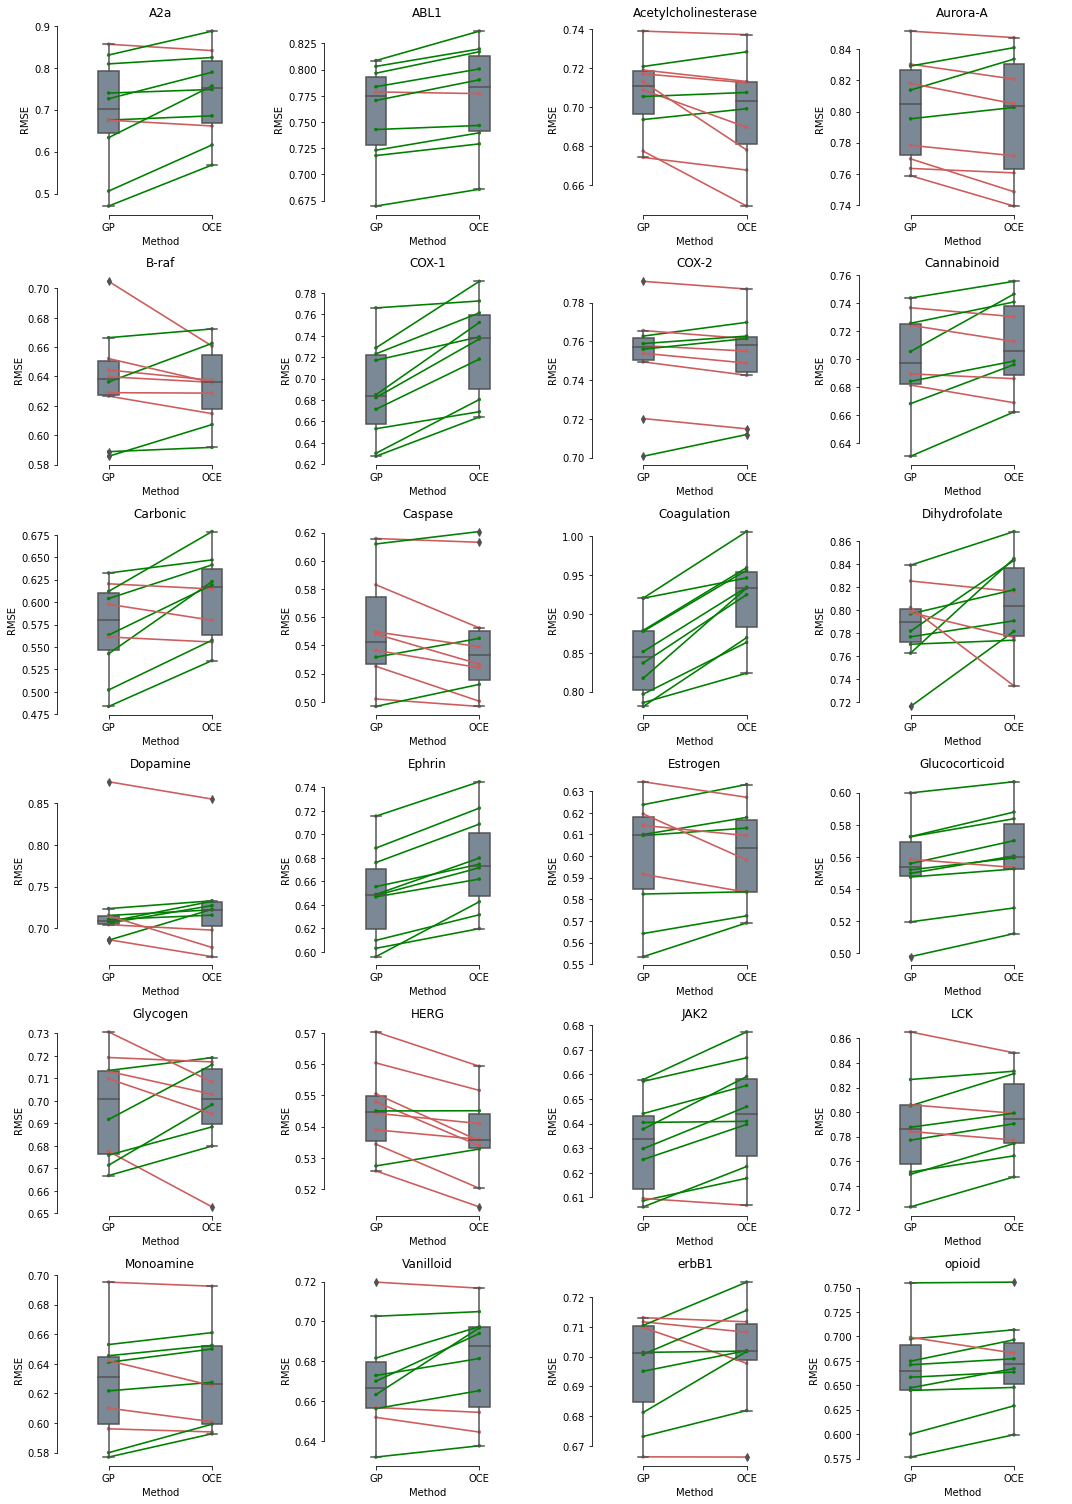

In [13]:
fig, axs = plt.subplots(nrows=6,ncols=4,figsize=(15,21))
for idx,ds in enumerate(sorted(melt_df.dataset.unique())):
    row = idx//4
    col = idx%4
    ax = plot_paired(data=melt_df.query("dataset == @ds"),dv="value",within="variable",subject="cycle",ax=axs[row,col])
    ax.set_title(ds)
    ax.set_ylabel("RMSE")
    ax.set_xlabel("Method")
    plt.tight_layout()